# Setting

<br>

## Import Modules

In [1]:
# (1) base
import sys,os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
import numpy as np
import time,datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# (2) plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# (3) stock data
# !pip install finance-datareader
import FinanceDataReader as fdr

# (4) modeling
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error

print('> torch version  :',torch.__version__)
print('> cuda available :',torch.cuda.is_available())

> torch version  : 1.14.0.dev20221202
> cuda available : False


In [2]:
from utils.data_loader import StockDataLoader
from models.torch_dataset import TimeSeriesDataset
# from models.torch_model import BiLSTM
from models.torch_build import train

In [3]:
sys.path.append('/Users/khj/Github/hyuckjinkim/lib-python/torch/')
from build_model import EarlyStopping
from torch_seed import seed_everything

<br>

## Initial Values

In [47]:
# data load
TICKER = 'QQQ'
START_DATE = '2010-01-01'
END_DATE = None

# data preprocess
SCALING = False
TARGET_LOGSCALE = False
LAG_LENGTH = 7

# train test split
SEED = 0
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1

# make sequences
SEQUENCE_SIZE = 7*20 #21
WINDOW_SIZE = 1
FUTURE_SIZE = 1

# data loader
BATCH_SIZE = 32 #32
SHUFFLE = False

# model
BIDIRECTIONAL = False
BATCH_NORM = False
HIDDEN_SIZE = 64 #64
NUM_LAYERS = 2 #2
DROPOUT = 0.5
LEARNING_RATE = 0.001

<br></br>

# Data Load

In [48]:
data_loader = StockDataLoader(
    ticker=TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    test_size=TEST_SIZE,
    validation_size=VALIDATION_SIZE,
    seed=SEED,
    scaling=SCALING,
    target_logscale=TARGET_LOGSCALE,
    lag_length=LAG_LENGTH,
)
train_data, validation_data, test_data = data_loader.get_data()

In [49]:
print('TrainSize: {}, ValidationSize: {}, TestSize: {}'.format(len(train_data),len(validation_data),len(test_data)))

TrainSize: 2673, ValidationSize: 333, TestSize: 333


In [50]:
print('Train Size: {:,} ({} ~ {})'.format(len(train_data),str(train_data.date.min())[:10],str(train_data.date.max())[:10]))
print('Valid Size: {:,} ({} ~ {})'.format(len(validation_data),str(validation_data.date.min())[:10],str(validation_data.date.max())[:10]))
print('Test  Size: {:,} ({} ~ {})'.format(len(test_data),str(test_data.date.min())[:10],str(test_data.date.max())[:10]))

Train Size: 2,673 (2010-01-04 ~ 2020-08-14)
Valid Size: 333 (2020-08-17 ~ 2021-12-09)
Test  Size: 333 (2021-12-10 ~ 2023-04-10)


In [51]:
data = pd.concat([
    train_data     .assign(group='train'),
    validation_data.assign(group='validation'),
    test_data      .assign(group='test'),
],axis=0)

idx_features = ['date','group']
lag_features = [f'adj_close_lag_{i+1}' for i in range(LAG_LENGTH)[::-1]]
target_features = ['adj_close']

data = data[idx_features+lag_features+target_features]

y_min, y_max = train_data.adj_close.min(), train_data.adj_close.max()
for col in lag_features+target_features:
    data[col] = (data[col]-y_min) / (y_max-y_min)

In [52]:
data.tail()

,date,group,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
3334,2023-04-03,test,1.168993,1.173891,1.164740,1.157695,1.181753,1.194470,1.217025,1.213674
3335,2023-04-04,test,1.173891,1.164740,1.157695,1.181753,1.194470,1.217025,1.213674,1.209034
3336,2023-04-05,test,1.164740,1.157695,1.181753,1.194470,1.217025,1.213674,1.209034,1.195501
3337,2023-04-06,test,1.157695,1.181753,1.194470,1.217025,1.213674,1.209034,1.195501,1.204652
3338,2023-04-10,test,1.181753,1.194470,1.217025,1.213674,1.209034,1.195501,1.204652,1.203878


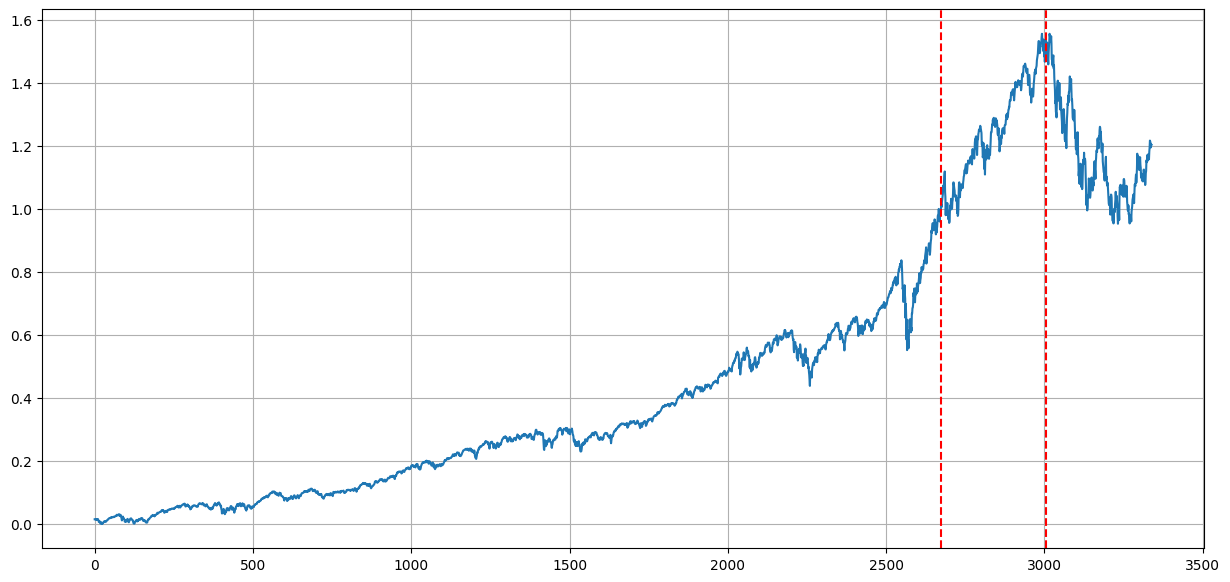

In [53]:
plt.figure(figsize=(15,7))
plt.plot(data.adj_close.tolist())
plt.axvline(len(train_data),color='red',linestyle='--')
plt.axvline(len(train_data)+len(validation_data),color='red',linestyle='--')
plt.grid()
plt.show()

<br></br>

# Dataset for PyTorch

In [54]:
# data_loader.get_data()[0].head()

In [55]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# 시계열 데이터셋 클래스 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, data, group, sequence_size, window_size, future_size, infer_mode):
        assert len([x for x in data['group'] if x not in ['train','validation','test']])==0, \
            "data['group'] must be in ['train','validation','test']"
        assert group in ['train','validation','test'], \
            "group must be in ['train','validation','test']"
        
        self.infer_mode = infer_mode
        self.group = group
        
        # make sequence
        self.tr_x_list, self.tr_y_list = [],[]
        self.va_x_list, self.va_y_list = [],[]
        self.te_x_list, self.te_y_list = [],[]
        i=0
        while True:
            if len(data)<i+sequence_size+future_size:
                break
            grp   = data.iloc[i+sequence_size:,:]['group'].values[0]
            seq_x = data.drop(['date','group'],axis=1).iloc[i:i+sequence_size,:].values
            seq_y = data.drop(['date','group'],axis=1).iloc[i+sequence_size:i+sequence_size+future_size,-1].values
            if grp=='train':
                self.tr_x_list.append(torch.Tensor(seq_x))
                self.tr_y_list.append(torch.Tensor(seq_y))
            elif grp=='validation':
                self.va_x_list.append(torch.Tensor(seq_x))
                self.va_y_list.append(torch.Tensor(seq_y))                
            elif grp=='test':
                self.te_x_list.append(torch.Tensor(seq_x))
                self.te_y_list.append(torch.Tensor(seq_y))
            else:
                raise ValueError("data['group'] must be in ['train','validation','test']")
            i+=window_size
            
        # make train/test set
        self.x_list, self.y_list = None, None
        if self.group=='train':
            self.x_list = self.tr_x_list.copy()
            self.y_list = self.tr_y_list.copy()
        elif self.group=='validation':
            self.x_list = self.va_x_list.copy()
            self.y_list = self.va_y_list.copy()            
        elif self.group=='test':
            self.x_list = self.te_x_list.copy()
            self.y_list = self.te_y_list.copy()
        else:
            raise ValueErorr("group must be in ['train','validation','test']")
            
    def __getitem__(self, index):
            
        data  = self.x_list[index]
        label = self.y_list[index]
        if self.infer_mode == False:
            return data, label
        else:
            return data

    def __len__(self):
        return len(self.x_list)

In [56]:
# 데이터셋 생성
train_dataset = TimeSeriesDataset(data, 'train'      , SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)
valid_dataset = TimeSeriesDataset(data, 'validation' , SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)
test_dataset  = TimeSeriesDataset(data, 'test'       , SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_dataloader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [57]:
[x for x,y in train_dataloader][0].size(), [y for x,y in train_dataloader][0].size()

(torch.Size([32, 140, 8]), torch.Size([32, 1]))

In [58]:
print([x for x,y in train_dataloader][0][0], [y for x,y in train_dataloader][0][0])
display(train_data.head(SEQUENCE_SIZE+1).tail())

tensor([[0.0099, 0.0112, 0.0128,  ..., 0.0135, 0.0119, 0.0144],
        [0.0112, 0.0128, 0.0137,  ..., 0.0119, 0.0144, 0.0144],
        [0.0128, 0.0137, 0.0129,  ..., 0.0144, 0.0144, 0.0134],
        ...,
        [0.0089, 0.0111, 0.0120,  ..., 0.0088, 0.0109, 0.0085],
        [0.0111, 0.0120, 0.0122,  ..., 0.0109, 0.0085, 0.0128],
        [0.0120, 0.0122, 0.0074,  ..., 0.0085, 0.0128, 0.0139]]) tensor([0.0154])


,date,open,high,low,volume,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,adj_close_lag_5,adj_close_lag_6,adj_close_lag_7,close_change,volume_change,close_ma_5,close_sd_5,volume_ma_5,volume_sd_5,bollinger_band_upper_5,bollinger_band_lower_5,close_ma_10,close_sd_10,volume_ma_10,volume_sd_10,bollinger_band_upper_10,bollinger_band_lower_10,close_ma_20,close_sd_20,volume_ma_20,volume_sd_20,bollinger_band_upper_20,bollinger_band_lower_20,close_ma_60,close_sd_60,volume_ma_60,volume_sd_60,bollinger_band_upper_60,bollinger_band_lower_60,close_ma_120,close_sd_120,volume_ma_120,volume_sd_120,bollinger_band_upper_120,bollinger_band_lower_120,macd_short,macd_long,macd,macd_signal,macd_sign,mean_close_change_1week,mean_volume_change_1week,mean_close_change_3week,mean_volume_change_3week,mean_close_change_6week,mean_volume_change_6week,mean_close_change_13week,mean_volume_change_13week,mean_close_change_26week,mean_volume_change_26week,mean_close_change_52week,mean_volume_change_52week,adj_close
136,2010-07-20,44.000000,45.259998,43.860001,89061200,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2010,39.698792,39.361454,40.479965,40.444466,40.240284,39.725422,39.610020,1.207498,8.875708,40.032566,0.488062,90674700.0,6.802465e+06,41.008691,39.056441,39.799986,0.513973,80617570.0,1.628066e+07,40.827932,38.772039,39.495938,1.046125,91542625.0,2.439568e+07,41.588188,37.403687,40.663782,1.658410,1.107912e+08,4.428222e+07,43.980601,37.346963,40.931388,1.912515,9.860937e+07,4.226984e+07,44.756419,37.106357,39.459842,39.902259,-0.442417,-0.733391,1,-0.020684,-0.390731,0.035798,7.587331,0.096904,4.013045,-0.117690,4.293271,0.004924,4.271806,0.112740,3.965302,40.178154
137,2010-07-21,45.740002,45.759998,44.560001,83577000,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2010,40.178154,39.698792,39.361454,40.479965,40.444466,40.240284,39.725422,-1.369869,-6.157788,39.869226,0.451005,89852680.0,7.469390e+06,40.771236,38.967216,39.860350,0.443317,81730430.0,1.603877e+07,40.746984,38.973716,39.428948,0.988224,90996805.0,2.444825e+07,41.405395,37.452500,40.581285,1.581760,1.110615e+08,4.406159e+07,43.744805,37.417764,40.941034,1.902893,9.746052e+07,4.074952e+07,44.746820,37.135249,39.620371,39.879217,-0.258847,-0.684704,1,-0.396139,-0.416980,0.201626,1.100269,0.057266,2.126977,-0.137833,4.550414,-0.015191,4.139713,0.106806,4.079892,39.627766
138,2010-07-22,45.270000,45.980000,45.240002,82890300,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2010,39.627766,40.178154,39.698792,39.361454,40.479965,40.444466,40.240284,2.531387,-0.821638,39.899413,0.504036,87232240.0,7.064187e+06,40.907484,38.891342,39.999722,0.444713,82193000.0,1.599434e+07,40.889148,39.110296,39.420532,0.976588,90521440.0,2.451193e+07,41.373707,37.467356,40.531276,1.530289,1.105662e+08,4.421069e+07,43.591854,37.470699,40.964634,1.881032,9.638377e+07,3.937893e+07,44.726698,37.202571,39.854877,39.853264,0.001613,-0.600015,1,0.092584,-2.475634,0.471836,2.759817,0.169556,2.878383,-0.106658,4.987294,0.003617,4.327891,0.114883,4.034948,40.630898
139,2010-07-23,45.459999,46.099998,45.380001,81056100,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,2010,40.630898,39.627766,40.178154,39.698792,39.361454,40.479965,40.444466,0.633565,-2.212804,40.204786,0.556436,83677080.0,3.162584e+06,41.317658,39.091915,40.127552,0.500473,85513490.0,1.061471e+07,41.128499,39.126606,39.455996,1.017600,88866950.0,2.394356e+07,41.491195,37.420797,40.485116,1.475156,1.097491e+08,4.429685e+07,43.435427,37.534805,40.986920,1.863934,9.591901e+07,3.922641e+07,44.714789,37.259051,40.010227,39.830750,0.179477,-0.492298,1,0.771921,-3.509783,0.532808,-1.163572,0.095587,3.623884,-0.105570,4.838105,0.017445,3.782698,0.109941,3.960285,40.888321
140,2010-07-26,46.119999,46.459999,45.910000,64850900,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2010,40.888321,40.630898,39.627766,40.178154,39.698792,39.361454,40.479965,0.825040,-19.99

<br></br>

# Modeling

In [59]:
class BiLSTM(nn.Module):
    def __init__(self, bidirectional, batch_norm, input_size, hidden_size, num_layers, output_size, dropout, seq_len):
        super(BiLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.batch_norm = batch_norm
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if self.bidirectional else 1
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=self.bidirectional))
        for i in range(num_layers-1):
            self.layers.append(
                nn.LSTM(hidden_size*self.num_directions, hidden_size, batch_first=True, bidirectional=self.bidirectional)
            )
        
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
        self.dropout = nn.Dropout(dropout)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(seq_len)     #LSTM Layer 뒤에 있을 때
            self.bn2 = nn.BatchNorm1d(output_size) #Fully Connected 뒤에 있을 때
        self.activation = nn.LeakyReLU(negative_slope=0.01) #nn.ELU()
        
        # 초기 가중치 설정
        self.init_weights()
        
    def init_weights(self):
        for layer in self.layers:
            for name, param in layer.named_parameters():
                if 'weight' in name:
                    init.xavier_normal_(param.data)
                elif 'bias' in name:
                    init.constant_(param.data, 0)
                
        init.xavier_normal_(self.fc.weight)
        init.constant_(self.fc.bias, 0)

    def forward(self, x):
        # 초기 hidden state와 cell state를 0으로 초기화
        h0 = torch.zeros(self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_directions, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out = x
        for i in range(self.num_layers):
            out, (hn, cn) = self.layers[i](out, (h0, c0))
            out = self.dropout(out)
            # if self.batch_norm:
            #     out = self.bn1(out)
            #out = self.activation(out)
        
        # Fully connected layer
        out = out[:, -1, :] # 마지막 타임스텝의 hidden state를 선택
        out = self.fc(out)
        if self.batch_norm:
            out = self.bn2(out)
        out = self.activation(out)
        
        return out

In [60]:
data.tail()

,date,group,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
3334,2023-04-03,test,1.168993,1.173891,1.164740,1.157695,1.181753,1.194470,1.217025,1.213674
3335,2023-04-04,test,1.173891,1.164740,1.157695,1.181753,1.194470,1.217025,1.213674,1.209034
3336,2023-04-05,test,1.164740,1.157695,1.181753,1.194470,1.217025,1.213674,1.209034,1.195501
3337,2023-04-06,test,1.157695,1.181753,1.194470,1.217025,1.213674,1.209034,1.195501,1.204652
3338,2023-04-10,test,1.181753,1.194470,1.217025,1.213674,1.209034,1.195501,1.204652,1.203878


In [61]:
# 모델 인스턴스 생성 및 손실함수, 최적화 함수 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTM(
    bidirectional=BIDIRECTIONAL,
    batch_norm=BATCH_NORM,
    input_size=data.shape[1]-len(idx_features), #train_data.shape[1]-1
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=FUTURE_SIZE,
    dropout=DROPOUT,
    seq_len=SEQUENCE_SIZE,
)
model = model.to(device)
print(model)

BiLSTM(
  (layers): ModuleList(
    (0): LSTM(8, 64, batch_first=True)
    (1): LSTM(64, 64, batch_first=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): LeakyReLU(negative_slope=0.01)
)


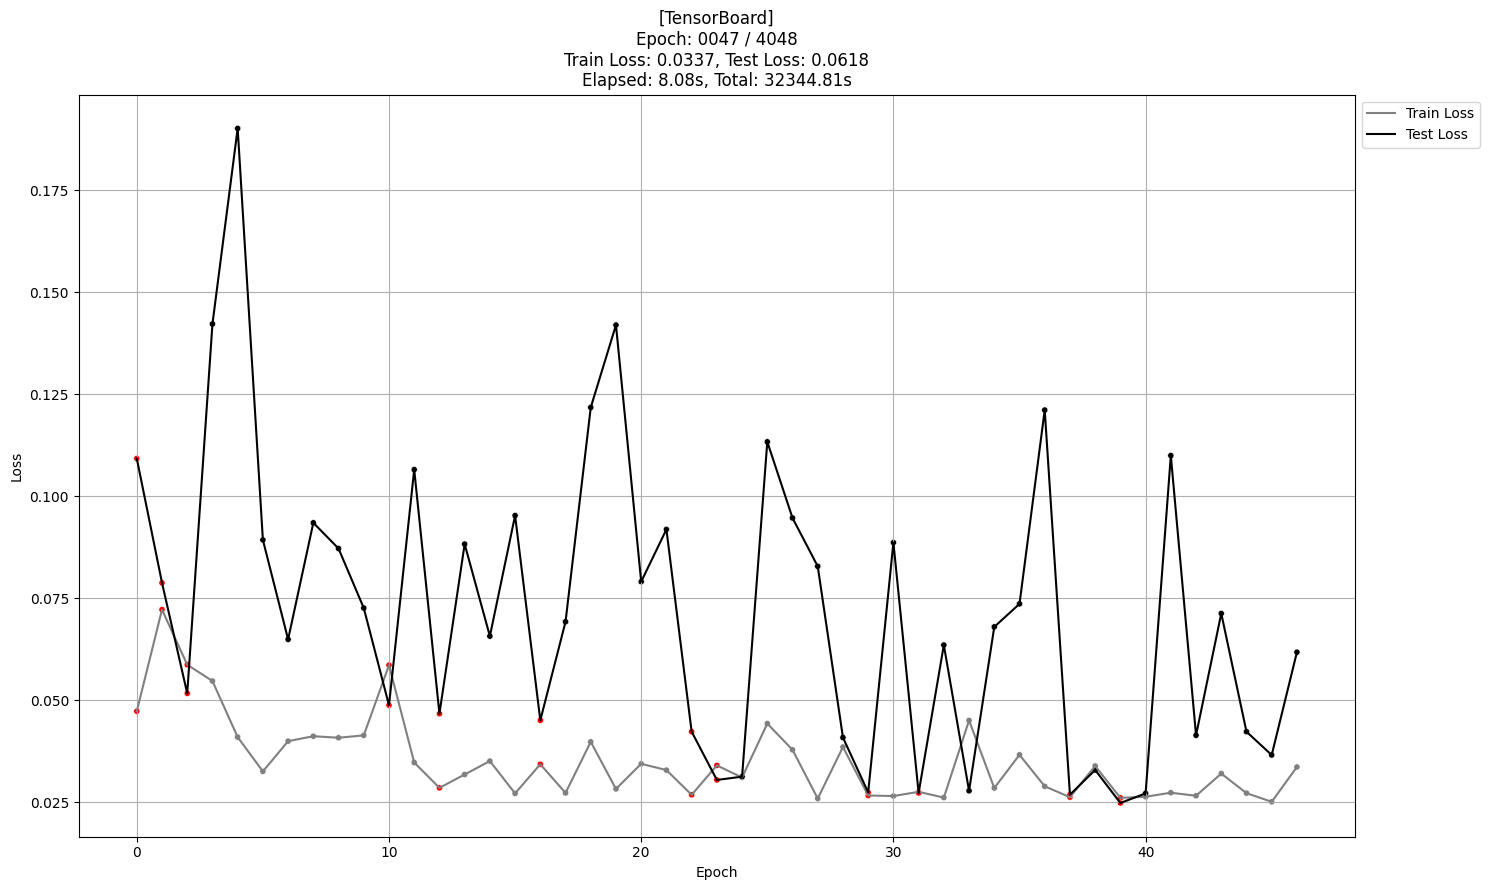


KeyboardInterrupt



In [62]:
%%time

seed_everything(SEED)

criterion = nn.L1Loss()  #nn.MSELoss(),nn.HuberLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=LEARNING_RATE,weight_decay=5e-4) # weight_decay: L2 regularization의 일종
# optimizer = torch.optim.SGD(params=model.parameters(),lr=lr,momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, threshold_mode='abs',min_lr=1e-7, verbose=False)
early_stopping = EarlyStopping(patience=30, verbose=False, path=None) #'./mc/checkpoint.pt'

best_model = train(
    model,
    train_dataloader,
    valid_dataloader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=4048,
    metric_period=1,
    target_logscale=TARGET_LOGSCALE,
    early_stopping=None,#early_stopping,
    plot=True,
    s=20,
)

<br></br>

# Inference

In [63]:
# 모델 인스턴스 생성 및 손실함수, 최적화 함수 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTM(
    bidirectional=BIDIRECTIONAL,
    batch_norm=BATCH_NORM,
    input_size=data.shape[1]-len(idx_features), #train_data.shape[1]-1
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=FUTURE_SIZE,
    dropout=DROPOUT,
    seq_len=SEQUENCE_SIZE,
)
model = model.to(device)
model.load_state_dict(torch.load('./mc/best_model.pt'))
# model.load_state_dict(torch.load('./mc/final_model.pt'))

<All keys matched successfully>

In [65]:
# for key,value in model.state_dict().items():
#     print(key)
#     print(value.numpy().round(3))

In [66]:
def predict(model, dataloader, device, target_logscale):
    with torch.no_grad():
        preds = []
        trues = []
        model.eval()
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            preds += output.detach().cpu().numpy().flatten().tolist()
            trues += y.detach().cpu().numpy().flatten().tolist()
            
    if target_logscale:
        preds = [np.exp(pred) for pred in preds]
        trues = [np.exp(true) for true in trues]
            
    return trues, preds

In [67]:
data.head()

,date,group,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
0,2010-01-04,train,0.009905,0.011157,0.012751,0.013662,0.012941,0.013472,0.011879,0.014421
1,2010-01-05,train,0.011157,0.012751,0.013662,0.012941,0.013472,0.011879,0.014421,0.014421
2,2010-01-06,train,0.012751,0.013662,0.012941,0.013472,0.011879,0.014421,0.014421,0.013359
3,2010-01-07,train,0.013662,0.012941,0.013472,0.011879,0.014421,0.014421,0.013359,0.013472
4,2010-01-08,train,0.012941,0.013472,0.011879,0.014421,0.014421,0.013359,0.013472,0.014915


In [68]:
def inverse_transform(y,y_min,y_max):
    new_y = np.array(y)*(y_max-y_min)+y_min
    return new_y.tolist()

Train RMSE: 4.421598660251367
Valid RMSE: 7.50461378107964
Test  RMSE: 11.661153678098588
(1) Train


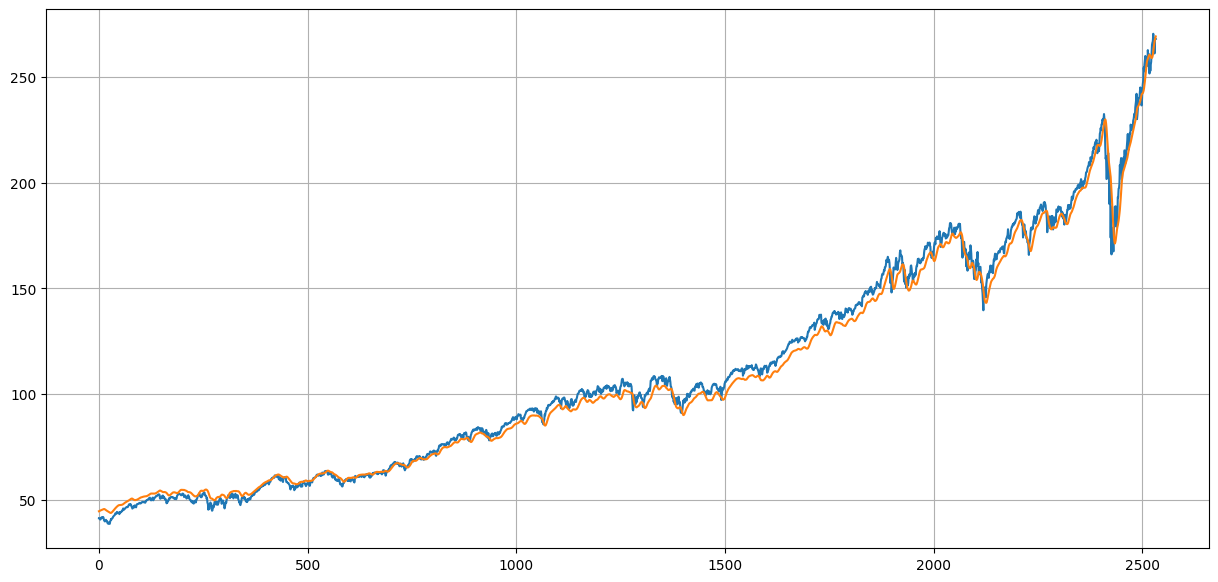

(2) Validation


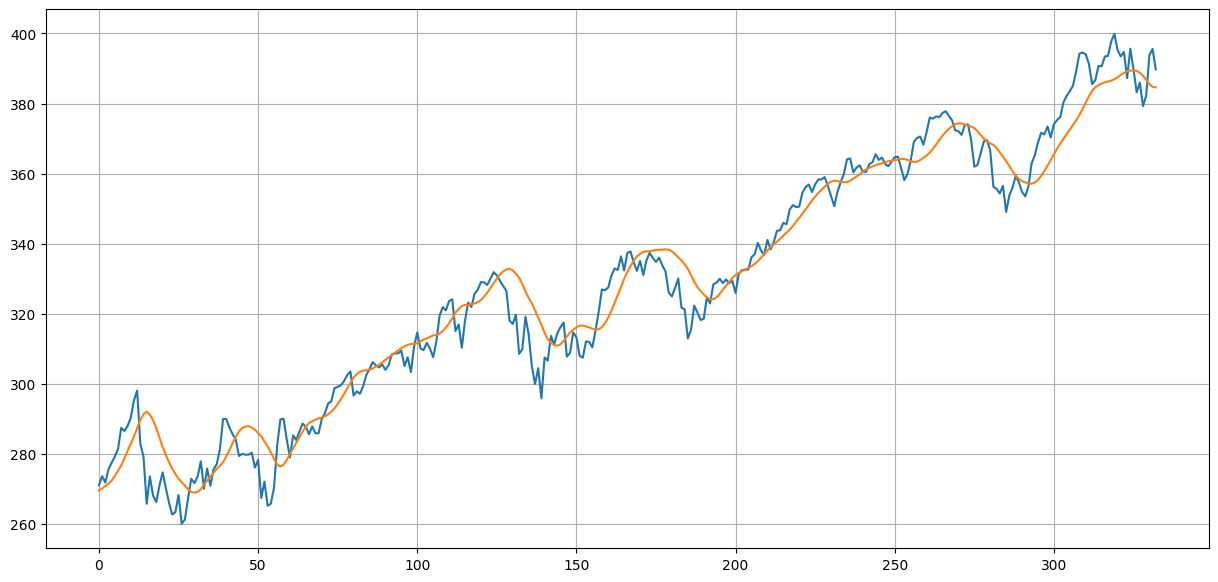

(3) Test


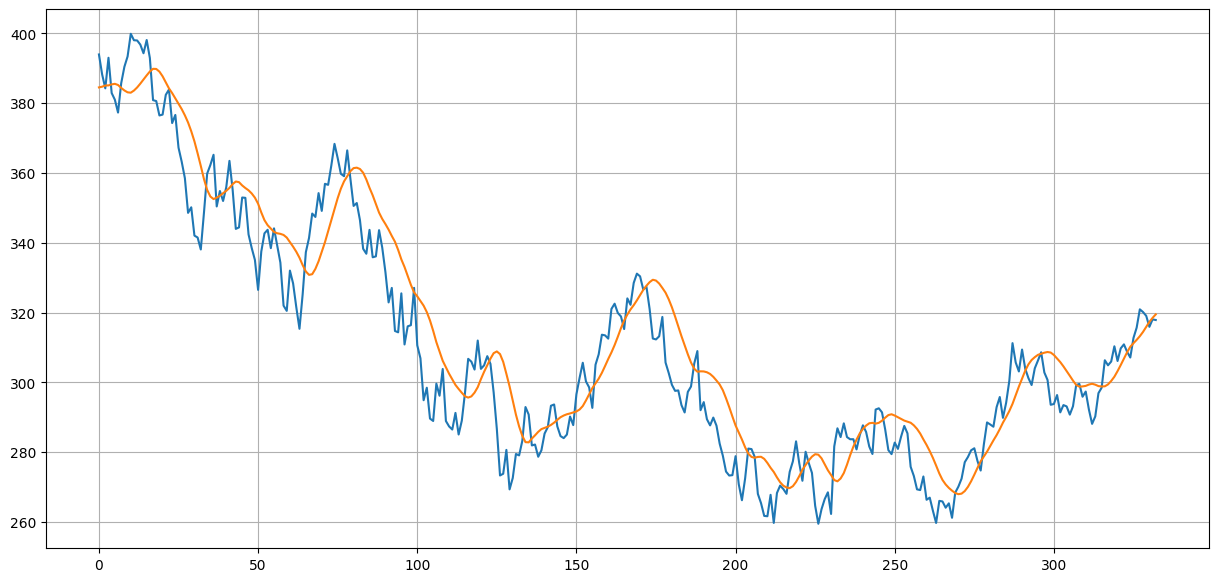

(3) Total


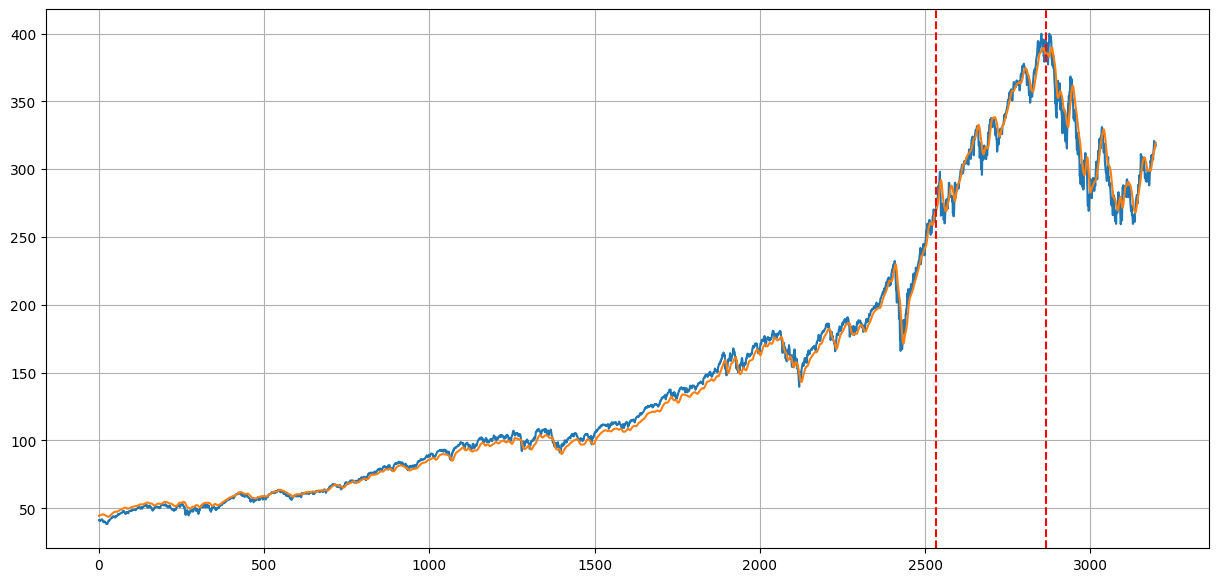

In [69]:
tr_trues, tr_preds = predict(model, train_dataloader, 'cpu', TARGET_LOGSCALE)
va_trues, va_preds = predict(model, valid_dataloader, 'cpu', TARGET_LOGSCALE)
te_trues, te_preds = predict(model, test_dataloader , 'cpu', TARGET_LOGSCALE)

tr_trues, tr_preds = inverse_transform(tr_trues,y_min,y_max), inverse_transform(tr_preds,y_min,y_max)
va_trues, va_preds = inverse_transform(va_trues,y_min,y_max), inverse_transform(va_preds,y_min,y_max)
te_trues, te_preds = inverse_transform(te_trues,y_min,y_max), inverse_transform(te_preds,y_min,y_max)

print(f'Train RMSE: {np.sqrt(mean_squared_error(tr_trues,tr_preds))}')
print(f'Valid RMSE: {np.sqrt(mean_squared_error(va_trues,va_preds))}')
print(f'Test  RMSE: {np.sqrt(mean_squared_error(te_trues,te_preds))}')

print('(1) Train')
plt.figure(figsize=(15,7))
plt.plot(tr_trues)
plt.plot(tr_preds)
plt.grid()
plt.show()

print('(2) Validation')
plt.figure(figsize=(15,7))
plt.plot(va_trues)
plt.plot(va_preds)
plt.grid()
plt.show()

print('(3) Test')
plt.figure(figsize=(15,7))
plt.plot(te_trues)
plt.plot(te_preds)
plt.grid()
plt.show()

print('(3) Total')
plt.figure(figsize=(15,7))
plt.plot(tr_trues+va_trues+te_trues)
plt.plot(tr_preds+va_preds+te_preds)
plt.axvline(len(tr_trues),color='red',linestyle='--')
plt.axvline(len(tr_trues)+len(va_trues),color='red',linestyle='--')
plt.grid()
plt.show()

In [70]:
len(tr_trues), len(train_data)

(2533, 2673)

In [71]:
data.head()

,date,group,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
0,2010-01-04,train,0.009905,0.011157,0.012751,0.013662,0.012941,0.013472,0.011879,0.014421
1,2010-01-05,train,0.011157,0.012751,0.013662,0.012941,0.013472,0.011879,0.014421,0.014421
2,2010-01-06,train,0.012751,0.013662,0.012941,0.013472,0.011879,0.014421,0.014421,0.013359
3,2010-01-07,train,0.013662,0.012941,0.013472,0.011879,0.014421,0.014421,0.013359,0.013472
4,2010-01-08,train,0.012941,0.013472,0.011879,0.014421,0.014421,0.013359,0.013472,0.014915


In [72]:
def predict_future(model, test_dataloader, n_future, sequence_size, target_logscale):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    last_21_days = [x for x,y in test_dataloader][-1][-1,:,:].unsqueeze(0)
    
    preds = []
    for i in range(n_future):
        with torch.no_grad():
            pred = model(last_21_days)
            preds.append(pred.item())
            
            new_data = torch.cat((last_21_days[:,-1,1:],pred),axis=1).unsqueeze(0)
            # print(last_21_days)
            # print(new_data)
            last_21_days = torch.cat((
                last_21_days[:,1:,:],
                new_data,
            ), axis=1)
            #    -3, -2, -1, -0
            # -> -2, -1, -0, pred
    
    if target_logscale:
        preds = np.exp(preds).tolist()
    
    return preds

In [75]:
n_future = 1000
future_k = predict_future(model, test_dataloader, n_future, SEQUENCE_SIZE, TARGET_LOGSCALE)
future_k = inverse_transform(future_k,y_min,y_max)

(3) Total


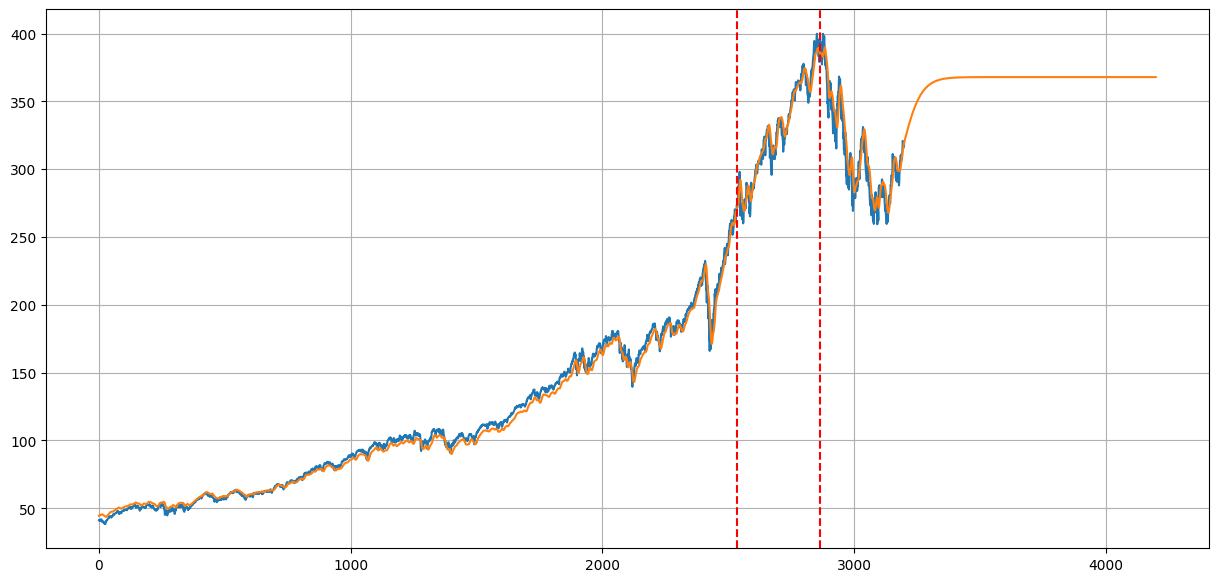

In [76]:
print('(3) Total')
plt.figure(figsize=(15,7))
plt.plot(tr_trues+va_trues+te_trues+[np.nan]*n_future)
plt.plot(tr_preds+va_preds+te_preds+future_k)
plt.axvline(len(tr_trues),color='red',linestyle='--')
plt.axvline(len(tr_trues+te_trues),color='red',linestyle='--')
plt.grid()
plt.show()

In [ ]:
# !pip install prophet

In [93]:
# conda install - c conda-forge fbprophet
import pandas as pd
from prophet import Prophet

# Initialize and fit model
m = Prophet(
    changepoint_prior_scale=0.2,
    n_changepoints=200,
    seasonality_mode=['multiplicative','additive'][0],
    weekly_seasonality=True,
    daily_seasonality=True,
    yearly_seasonality=True,
)
m.fit(data[data['group']!='test'][['date','adj_close']].rename(columns={'date':'ds','adj_close':'y'}))

12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1] done processing


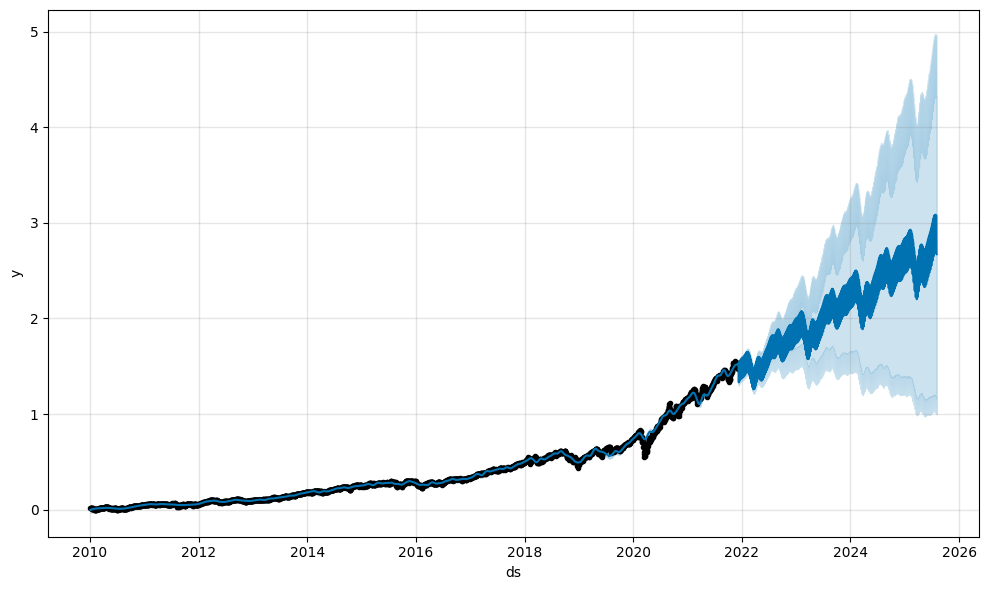

In [95]:
# Make future predictions
future = m.make_future_dataframe(periods=len(data[data['group']=='test'])+n_future)
forecast = m.predict(future)

# Plot forecast
fig = m.plot(forecast)

In [85]:
train_size = len(data[data['group']!='test'])
test_size  = len(data[data['group']=='test'])


tr_pred = forecast[:train_size]['yhat'].values.tolist()
te_pred = forecast[train_size:-n_future]['yhat'].values.tolist()
fc_pred = forecast[-n_future:]['yhat'].values.tolist()

tr_pred = inverse_transform(tr_pred,y_min,y_max)
te_pred = inverse_transform(te_pred,y_min,y_max)
fc_pred = inverse_transform(fc_pred,y_min,y_max)

tr_true = data[data['group']!='test'].adj_close.values.tolist()
te_true = data[data['group']=='test'].adj_close.values.tolist()
tr_true = inverse_transform(tr_true,y_min,y_max)
te_true = inverse_transform(te_true,y_min,y_max)

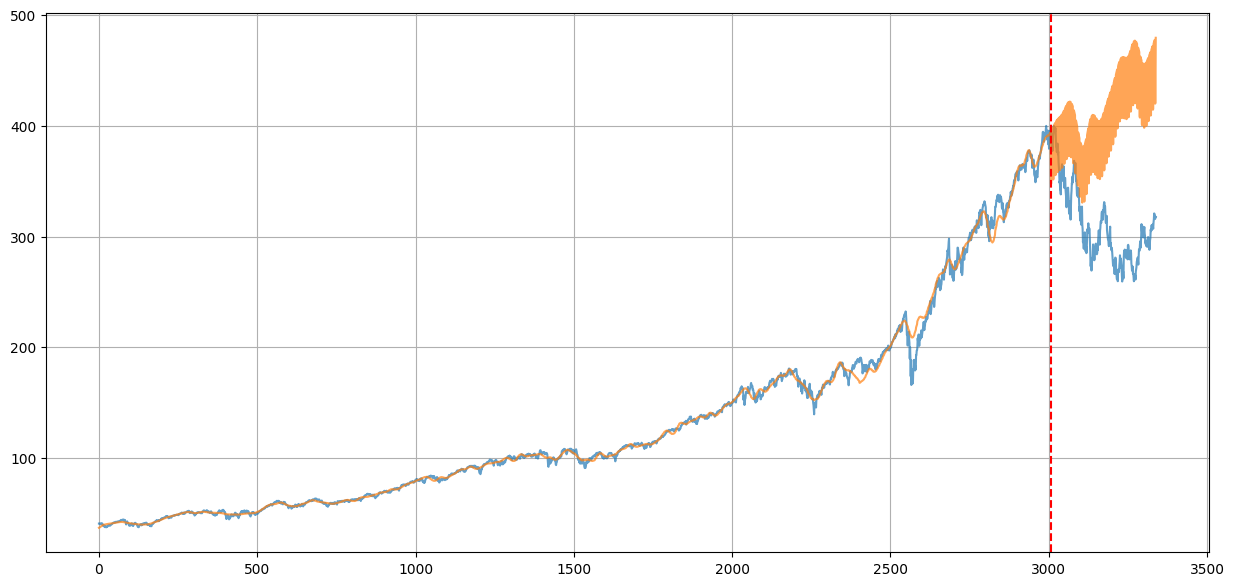

In [86]:
plt.figure(figsize=(15,7))
plt.plot(tr_true+te_true,alpha=0.7)
plt.plot(tr_pred+te_pred,alpha=0.7)
plt.grid()
plt.axvline(len(tr_true),color='red',linestyle='--')
plt.show()

In [89]:
tmp = forecast['yhat'].values.tolist()
tmp = inverse_transform(tmp,y_min,y_max)

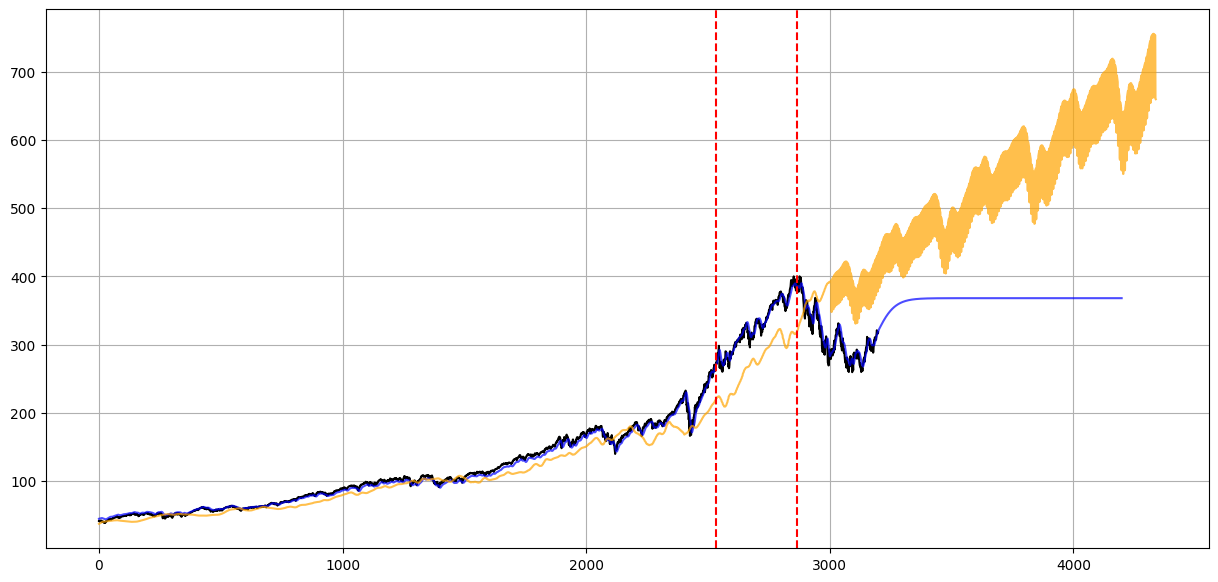

In [91]:
plt.figure(figsize=(15,7))
plt.plot(tr_trues+va_trues+te_trues,color='black')
plt.plot(tr_preds+va_preds+te_preds+future_k,color='blue',alpha=0.7)
plt.plot(tmp,color='orange',alpha=0.7)
plt.axvline(len(tr_trues),color='red',linestyle='--')
plt.axvline(len(tr_trues+va_trues),color='red',linestyle='--')
plt.grid()
plt.show()